# MICROSOFT STOCK PRICE TIME SERIES ANALYSIS

Within this Jupyter Notebook, we will attempt to forecast and model the future price of Microsoft stock through Time Series Analysis and SARIMAX models, while also modelling out potential trades and profits that could be made based on our forecast through training and test sets

## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARMA
from pmdarima import auto_arima

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, roc_auc_score

## Reading in the Stock Price Data and Preprocessing the Data

In [2]:
MSFT = pd.read_csv('MSFT.csv')
MSFT.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-08,125.440002,126.370003,124.750000,125.510002,123.871117,28419000
1,2019-05-09,124.290001,125.790001,123.570000,125.500000,123.861244,27235800
2,2019-05-10,124.910004,127.930000,123.820000,127.129997,125.469955,30915100
3,2019-05-13,124.110001,125.550003,123.040001,123.349998,121.739311,33944900
4,2019-05-14,123.870003,125.879997,123.699997,124.730003,123.101303,25266300


In [3]:
MSFT.Date = pd.to_datetime(MSFT.Date)
MSFT = MSFT.sort_values('Date')
MSFT.Date = MSFT.Date + timedelta(hours = 16)

In [4]:
stock = MSFT[['Date', 'Close']].copy()
stock.columns = ['Date', 'Price']
MSFT.Date = MSFT.Date - timedelta(hours = 6.5)
MSFT.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-08 09:30:00,125.440002,126.370003,124.750000,125.510002,123.871117,28419000
1,2019-05-09 09:30:00,124.290001,125.790001,123.570000,125.500000,123.861244,27235800
2,2019-05-10 09:30:00,124.910004,127.930000,123.820000,127.129997,125.469955,30915100
3,2019-05-13 09:30:00,124.110001,125.550003,123.040001,123.349998,121.739311,33944900
4,2019-05-14 09:30:00,123.870003,125.879997,123.699997,124.730003,123.101303,25266300


In [5]:
stock.head()

,Date,Price
0,2019-05-08 16:00:00,125.510002
1,2019-05-09 16:00:00,125.500000
2,2019-05-10 16:00:00,127.129997
3,2019-05-13 16:00:00,123.349998
4,2019-05-14 16:00:00,124.730003


In [6]:
MSFT.columns = ['Date', 'Price', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
stock = pd.concat([stock, MSFT[['Date', 'Price']]], axis = 0)
stock = stock.sort_values('Date')
stock.set_index(stock.Date, inplace = True)
stock = stock.drop('Date', 1)
stock.head()

,Price
Date,
2019-05-08 09:30:00,125.440002
2019-05-08 16:00:00,125.510002
2019-05-09 09:30:00,124.290001
2019-05-09 16:00:00,125.500000
2019-05-10 09:30:00,124.910004


## Creating a Function to Test for Stationarity

In [7]:
def test_stationarity(timeseries):
    rolmean = pd.Series(timeseries).rolling(12).mean()
    rolstd = pd.Series(timeseries).rolling(12).mean()
    fig = plt.figure(figsize = (12, 8))
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Average')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Standard Deviation')
    plt.legend(loc = 'best')
    plt.title('Comparison of Stock Price, Rolling Average, and Rolling Standard Deviation')
    plt.show()
    print('Results of Augmented Dickey-Fuller Test: ')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0: 4], index = ['Test Statistic', 'P-Value', 'No. Lags Used', 'No. Observations Used'])
    for key, value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

Now let us examine the stock price's Autocorrelation and Partial Autocorrelation plots

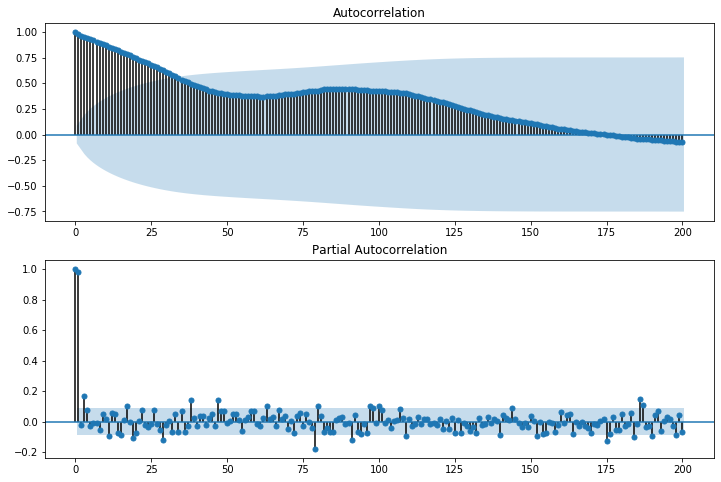

In [8]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stock.Price, lags = 200, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stock.Price, lags = 200, ax = ax2)
plt.show()

We can see that the Autocorrelation of the Microsoft stock prices is weak, perhaps suggesting that the autocorrelation is not statistically significant within the 95% confidence interval. Observing the Partial Autocorrelation graph, however, while we also do not see clear significant indication of partial autocorrelation within the 95% confidence interval, the results seem more promising in comparison to the Autocorrelation graph and the existence of significant partial autocorrelation may exist. We can also observe the graphs for different lag values.

## Building the SARIMAX Model

In [9]:
optimal = auto_arima(stock.Price, start_p = 0, start_q = 0, test = 'adf', seasonal = True)
optimal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  508
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -1159.824
Date:                Sat, 09 May 2020   AIC                           2329.648
Time:                        14:24:50   BIC                           2350.791
Sample:                             0   HQIC                          2337.940
                                - 508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1620      0.120      1.350      0.177      -0.073       0.397
ar.L1         -0.0188      0.028     -0.682      0.495      -0.073       0.035
ar.L2         -0.2450      0.029     -8.518      0.000      -0.301      -0.189
ar.L3         -0.1238      0.029     -4.309      0.000      -0.180      -0.068
sigma2         5.6805      0.171     33.180      0.000       5.345       6.016
===================================================================================
Ljung-Box (Q):                       95.99   Jarque-Bera (JB):              2115.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.48   Skew:                            -1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
model = sm.tsa.statespace.SARIMAX(stock.Price, trend = 'n', order = (3, 1, 0))
results = model.fit()
results.summary()

/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  508
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -1160.981
Date:                Sat, 09 May 2020   AIC                           2329.962
Time:                        14:24:50   BIC                           2346.876
Sample:                             0   HQIC                          2336.595
                                - 508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0147      0.028     -0.535      0.593      -0.069       0.039
ar.L2         -0.2420      0.029     -8.474      0.000      -0.298      -0.186
ar.L3         -0.1198      0.028     -4.330      0.000      -0.174      -0.066
sigma2         5.7065      0.165     34.559      0.000       5.383       6.030
===================================================================================
Ljung-Box (Q):                       96.99   Jarque-Bera (JB):              2129.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.45   Skew:                            -1.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

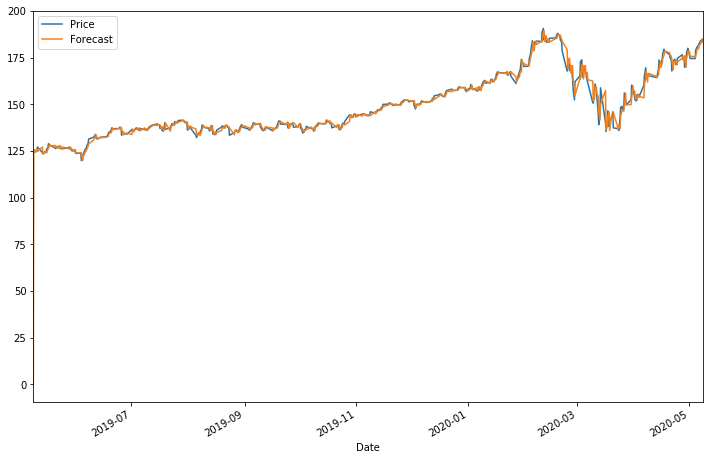

In [11]:
stock['Forecast'] = results.predict(dynamic = False)
stock[['Price', 'Forecast']].plot(figsize = (12, 8))
plt.show()

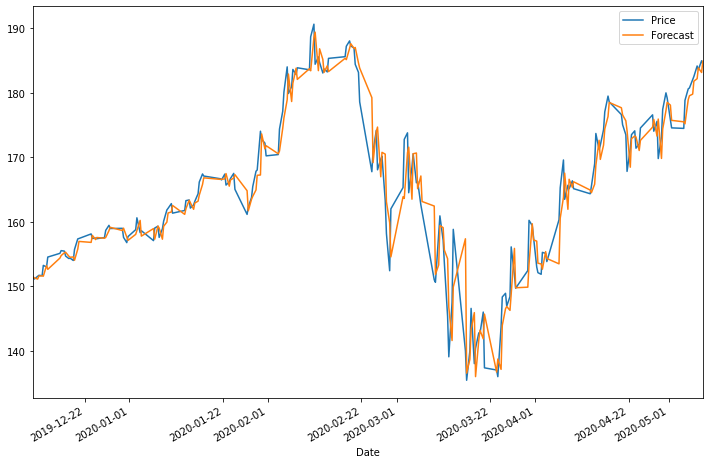

In [12]:
stock[['Price', 'Forecast']].iloc[300:].plot(figsize = (12, 8))
plt.show()

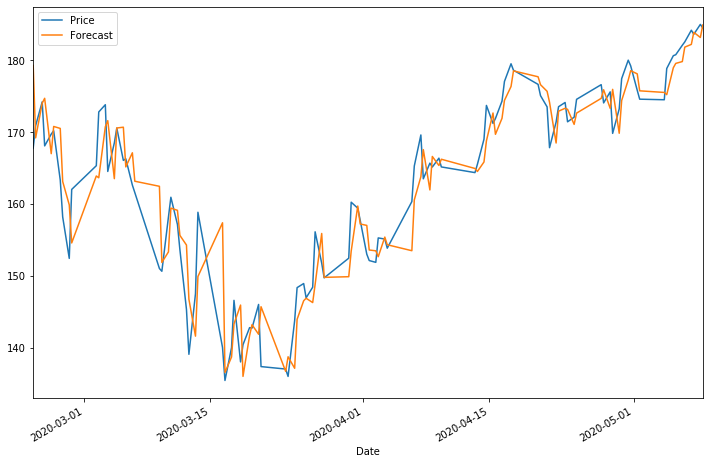

In [13]:
stock['Forecast'] = [np.NaN for i in range(300)] + list(results.predict(start = 300, end = 507, dynamic = False))
stock[['Price', 'Forecast']].iloc[400:].plot(figsize = (12, 8))
plt.show()

In [14]:
def calculate_profit(timeseries, predictions, stop):
    capital = 0
    transactions = 0
    own = False
    last_buy = 0
    current_price = 0
    for num, i in enumerate(timeseries.iloc[:stop].iterrows()):
        if i[1][predictions] == 1 and own == False:
            capital -= i[1]['Price']
            own = True
            transactions += 1
            last_buy = i[1]['Price']
        elif i[1][predictions] == 0 and own == True:
            capital += i[1]['Price']
            own = False
            transactions += 1
        else:
            pass
        current_price = i[1]['Price']
    print('Currently Owning?: ', own)
    print('Last Buying Price: $', last_buy)
    print('Current Price: $', current_price)
    print('Current Cash: $', capital)
    if own == True:
        print('Profit: $', current_price + capital)
    else:
        print('Profit: $', capital)
    print('Number of Transactins:', transactions)
    print('Cost of transactions: $', transactions * 5)

The above function simulates trading using our SARIMAX predictions, and we assume a $5 transaction fee.

In [15]:
stock['Target'] = stock.Price.shift(-1)
stock.tail()

,Price,Forecast,Target
Date,,,
2020-05-06 16:00:00,182.539993,181.813375,184.169998
2020-05-07 09:30:00,184.169998,182.196946,183.600006
2020-05-07 16:00:00,183.600006,183.876469,184.979996
2020-05-08 09:30:00,184.979996,183.158768,184.470001
2020-05-08 16:00:00,184.470001,184.902302,NaN


In [16]:
stock['Forecast'] = results.predict(dynamic = False)
stock['Predicted Growth'] = stock[['Forecast', 'Price']].apply(lambda x: 1 if x[0] - x[1] >= 0 else 0, axis = 1)
stock['Actual Growth'] = stock[['Target', 'Price']].apply(lambda x: 1 if x[0] - x[1] >= 0 else 0, axis = 1)

In [17]:
calculate_profit(stock.iloc[300:], 'Predicted Growth', -1)

Currently Owning?:  False
Last Buying Price: $ 183.600006
Current Price: $ 184.979996
Current Cash: $ 11.70993299999995
Profit: $ 11.70993299999995
Number of Transactins: 100
Cost of transactions: $ 500


In [18]:
calculate_profit(stock.iloc[300:], 'Actual Growth', -1)

Currently Owning?:  False
Last Buying Price: $ 183.600006
Current Price: $ 184.979996
Current Cash: $ 270.4299149999998
Profit: $ 270.4299149999998
Number of Transactins: 98
Cost of transactions: $ 490


In [19]:
stock.head()

,Price,Forecast,Target,Predicted Growth,Actual Growth
Date,,,,,
2019-05-08 09:30:00,125.440002,0.000000,125.510002,0,1
2019-05-08 16:00:00,125.510002,125.440011,124.290001,0,0
2019-05-09 09:30:00,124.290001,125.510628,125.500000,1,1
2019-05-09 16:00:00,125.500000,124.255199,124.910004,0,0
2019-05-10 09:30:00,124.910004,125.769062,127.129997,1,1


## Building the ARMA Model

In [20]:
model = ARMA(stock.Price, (3, 1)).fit()
model.summary()

/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                  508
Model:                     ARMA(3, 1)   Log Likelihood               -1166.438
Method:                       css-mle   S.D. of innovations              2.393
Date:                Sat, 09 May 2020   AIC                           2344.877
Time:                        14:24:51   BIC                           2370.260
Sample:                             0   HQIC                          2354.830
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         152.2060     17.264      8.816      0.000     118.369     186.043
ar.L1.Price     1.2936      0.121     10.647      0.000       1.055       1.532
ar.L2.Price    -0.5486      0.125     -4.383      0.000      -0.794      -0.303
ar.L3.Price     0.2522      0.044      5.784      0.000       0.167       0.338
ma.L1.Price    -0.3010      0.122     -2.461      0.014      -0.541      -0.061
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0030           -0.0000j            1.0030           -0.0000
AR.2            0.5862           -1.9001j            1.9884           -0.2024
AR.3            0.5862           +1.9001j            1.9884            0.2024
MA.1            3.3222           +0.0000j            3.3222            0.0000
-----------------------------------------------------------------------------
"""

In [21]:
stock['Forecast'] = model.predict()
stock['Target'] = stock.Price.shift(-1)
stock.head()

,Price,Forecast,Target,Predicted Growth,Actual Growth
Date,,,,,
2019-05-08 09:30:00,125.440002,152.206031,125.510002,0,1
2019-05-08 16:00:00,125.510002,125.598477,124.290001,0,0
2019-05-09 09:30:00,124.290001,125.671496,125.500000,1,1
2019-05-09 16:00:00,125.500000,124.377718,124.910004,0,0
2019-05-10 09:30:00,124.910004,125.906158,127.129997,1,1


Score:  0.9566082335540104
MSE:  11.747995736071015


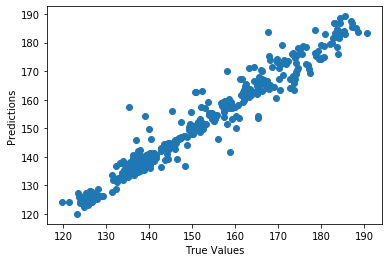

In [22]:
plt.scatter(stock.iloc[1: -1].Target, stock.iloc[1: -1].Forecast)
plt.xlabel('True Values')
plt.ylabel('Predictions')
print('Score: ', metrics.r2_score(stock.iloc[1: -1].Target, stock.iloc[1: -1].Forecast))
print('MSE: ', metrics.mean_squared_error(stock.iloc[1: -1].Target, stock.iloc[1: -1].Forecast))
plt.show()

In [23]:
stock['Predicted Growth'] = stock[['Forecast', 'Price']].apply(lambda x: 1 if x[0] - x[1] >= 5 else 0 if x[0] - x[1] <= -5 else 2, axis = 1)
stock['Actual Growth'] = stock[['Target', 'Price']].apply(lambda x: 1 if x[0] - x[1] >= 5 else 0 if x[0] - x[1] <= -5 else 2, axis = 1)

In [24]:
print('Model Results: ')
calculate_profit(stock.iloc[300:], 'Predicted Growth', -1)
print('\nBest Case Results: ')
calculate_profit(stock.iloc[300:], 'Actual Growth', -1)

Model Results: 
Currently Owning?:  True
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ -197.660003
Profit: $ -12.68000699999999
Number of Transactins: 7
Cost of transactions: $ 35

Best Case Results: 
Currently Owning?:  False
Last Buying Price: $ 135.979996
Current Price: $ 184.979996
Current Cash: $ 106.96002100000001
Profit: $ 106.96002100000001
Number of Transactins: 12
Cost of transactions: $ 60


In [25]:
rolmean = pd.Series(stock.Price).rolling(20).mean()
stock['Rolling Mean'] = rolmean
stock.head()

,Price,Forecast,Target,Predicted Growth,Actual Growth,Rolling Mean
Date,,,,,,
2019-05-08 09:30:00,125.440002,152.206031,125.510002,1,2,NaN
2019-05-08 16:00:00,125.510002,125.598477,124.290001,2,2,NaN
2019-05-09 09:30:00,124.290001,125.671496,125.500000,2,2,NaN
2019-05-09 16:00:00,125.500000,124.377718,124.910004,2,2,NaN
2019-05-10 09:30:00,124.910004,125.906158,127.129997,2,2,NaN


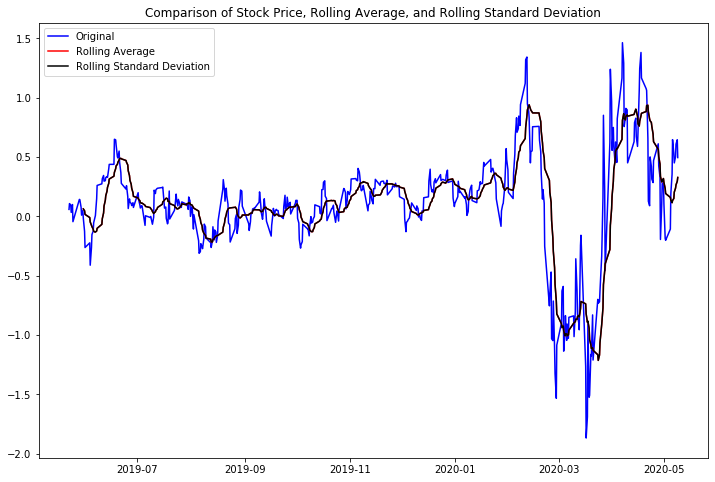

Results of Augmented Dickey-Fuller Test: 
Test Statistic            -4.998314
P-Value                    0.000022
No. Lags Used             18.000000
No. Observations Used    469.000000
Critical Value (1%)       -3.444370
Critical Value (5%)       -2.867722
Critical Value (10%)      -2.570063
dtype: float64


In [26]:
stock['First Difference'] = stock['Rolling Mean'] - stock['Rolling Mean'].shift(1)
test_stationarity(stock['First Difference'].dropna(inplace = False))

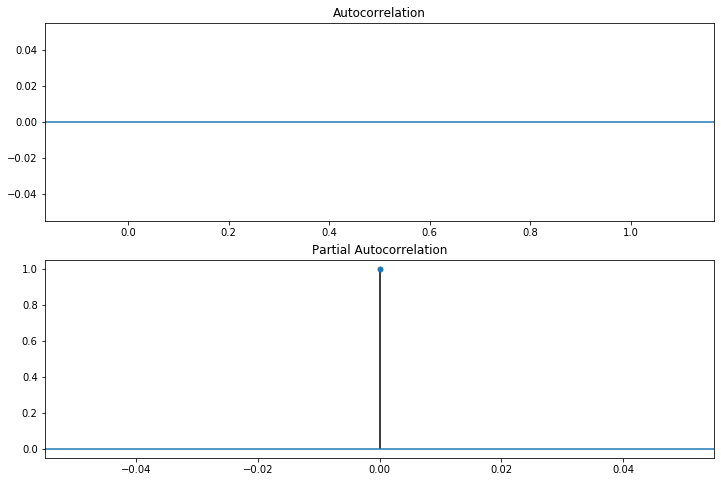

In [27]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stock['Rolling Mean'].iloc[5:], lags=10, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stock['Rolling Mean'].iloc[5:], lags=5, ax=ax2)
plt.show()

In [28]:
optimal = auto_arima(stock['Rolling Mean'].dropna(inplace = False), start_p = 0, start_q = 0, test = 'adf', seasonal = True)
optimal.summary()

/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameter

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  489
Model:               SARIMAX(4, 0, 0)   Log Likelihood                 180.380
Date:                Sat, 09 May 2020   AIC                           -348.760
Time:                        14:24:54   BIC                           -323.606
Sample:                             0   HQIC                          -338.880
                                - 489                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1240      0.073      1.700      0.089      -0.019       0.267
ar.L1          2.0212      0.021     94.269      0.000       1.979       2.063
ar.L2         -1.4137      0.052    -27.352      0.000      -1.515      -1.312
ar.L3          0.7101      0.058     12.257      0.000       0.597       0.824
ar.L4         -0.3184      0.026    -12.377      0.000      -0.369      -0.268
sigma2         0.0273      0.001     26.432      0.000       0.025       0.029
===================================================================================
Ljung-Box (Q):                      220.93   Jarque-Bera (JB):               700.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.80   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
model = sm.tsa.statespace.SARIMAX(stock['Rolling Mean'], trend = 'n', order = (4, 0, 0))
results = model.fit()
results.summary()

/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Rolling Mean   No. Observations:                  508
Model:               SARIMAX(4, 0, 0)   Log Likelihood                   2.476
Date:                Sat, 09 May 2020   AIC                              5.049
Time:                        14:24:55   BIC                             26.201
Sample:                             0   HQIC                            13.343
                                - 508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3261      0.021     63.797      0.000       1.285       1.367
ar.L2          0.6185      0.021     29.021      0.000       0.577       0.660
ar.L3         -1.3258      0.021    -63.763      0.000      -1.367      -1.285
ar.L4          0.3813      0.021     17.889      0.000       0.339       0.423
sigma2         0.0554      0.001     39.795      0.000       0.053       0.058
===================================================================================
Ljung-Box (Q):                      724.81   Jarque-Bera (JB):              3094.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.29   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
stock['Forecast'] = results.predict()
stock['Target'] = stock['Rolling Mean'].shift(-1)

Score:  0.9984937509713085
MSE: 0.35508330266433424


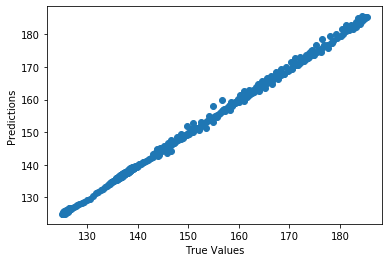

In [31]:
plt.scatter(stock.iloc[21:-1].Target, stock.iloc[21:-1].Forecast)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score: ", metrics.r2_score(stock.iloc[21:-1].Target, stock.iloc[21:-1].Forecast))
print("MSE:", metrics.mean_squared_error(stock.iloc[21:-1].Target, stock.iloc[21:-1].Forecast))
plt.show()

In [32]:
stock['Predicted Growth'] = stock[['Forecast', 'Price']].apply(lambda x: 1 if x[0] - x[1] >= 0 else 0, axis = 1)
stock['Actual Growth'] = stock[['Target', 'Price']].apply(lambda x: 1 if x[0] - x[1] >= 0 else 0, axis = 1)

In [33]:
print("Model Resuls: ")
calculate_profit(stock.iloc[300:], 'Predicted Growth', -1)
print("\nBest Case Results:")
calculate_profit(stock.iloc[300:], 'Actual Growth', -1)

Model Resuls: 
Currently Owning?:  False
Last Buying Price: $ 169.809998
Current Price: $ 184.979996
Current Cash: $ 0.569991999999985
Profit: $ 0.569991999999985
Number of Transactins: 20
Cost of transactions: $ 100

Best Case Results:
Currently Owning?:  False
Last Buying Price: $ 169.809998
Current Price: $ 184.979996
Current Cash: $ 20.939986999999974
Profit: $ 20.939986999999974
Number of Transactins: 24
Cost of transactions: $ 120


In [34]:
def evaluate_model(truth, predictions, model = None, X = None):
    cm = confusion_matrix(truth, predictions)

    print('True Negative: ', cm[0, 0], '| False Positive: ', cm[0, 1])
    print('False Negative: ', cm[1, 0], '| True Positive: ', cm[1, 1], '\n')

    sensitivity = cm[1, 1]/ (cm[1, 0] + cm[1, 1])
    specificity = cm[0, 0]/ (cm[0, 1] + cm[0, 0])

    print('Sensitivity (TP/ TP + FN): ', sensitivity)
    print('Specificity (TN/ TN + FP): ', specificity, '\n')

    print('Accuracy: ', accuracy_score(truth, predictions, normalize = True))
    print('Precision: ', precision_score(truth, predictions))
    if model != None:
        print('Roc-Auc: ', roc_auc_score(truth, [x[1] for x in model.predict_proba(X)]))
    else:
        pass
    print('\n')

In [35]:
evaluate_model(stock['Actual Growth'], stock['Predicted Growth'])

True Negative:  351 | False Positive:  5
False Negative:  5 | True Positive:  147 

Sensitivity (TP/ TP + FN):  0.9671052631578947
Specificity (TN/ TN + FP):  0.9859550561797753 

Accuracy:  0.9803149606299213
Precision:  0.9671052631578947




In [36]:
stock['Predicted Growth'] = stock[['Forecast', 'Price']].apply(lambda x: 1 if x[0] - x[1] >= 5 else 0 if x[0] - x[1] <= -5 else 2, axis = 1)
stock['Actual Growth'] = stock[['Target', 'Price']].apply(lambda x: 1 if x[0] - x[1] >= 5 else 0 if x[0] - x[1] <= -5 else 2, axis = 1)

In [37]:
print("Model Resuls: ")
calculate_profit(stock.iloc[300:], 'Predicted Growth', -1)
print("\nBest Case Results:")
calculate_profit(stock.iloc[300:], 'Actual Growth', -1)

Model Resuls: 
Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -29.67999199999997
Profit: $ -29.67999199999997
Number of Transactins: 2
Cost of transactions: $ 10

Best Case Results:
Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -29.67999199999997
Profit: $ -29.67999199999997
Number of Transactins: 2
Cost of transactions: $ 10


In [38]:
profits = []
for i in range(1, 30):
    rolmean = pd.Series(stock.Price).rolling(i).mean()
    stock['Rolling Mean'] = rolmean
    model = sm.tsa.statespace.SARIMAX(stock['Rolling Mean'], trend='n', order=(4, 0, 0))
    results = model.fit()
    results.summary()
    stock['Forecast'] = results.predict()
    stock['Target'] = stock['Rolling Mean'].shift(-1)
    stock['Predicted Growth'] = stock[['Forecast', 'Price']].apply(lambda x: 1 if x[0] - x[1] >= 5 else 0 if x[0] - x[1] <= -5 else 2, axis = 1)
    calculate_profit(stock.iloc[300:], 'Predicted Growth', -1)

/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

Currently Owning?:  True
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ -197.660003
Profit: $ -12.68000699999999
Number of Transactins: 7
Cost of transactions: $ 35


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ -11.22001499999999
Profit: $ -11.22001499999999
Number of Transactins: 12
Cost of transactions: $ 60


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ 22.020020000000045
Profit: $ 22.020020000000045
Number of Transactins: 16
Cost of transactions: $ 80


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ 38.890000000000015
Profit: $ 38.890000000000015
Number of Transactins: 16
Cost of transactions: $ 80


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ 46.23001100000002
Profit: $ 46.23001100000002
Number of Transactins: 14
Cost of transactions: $ 70


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ 25.819991999999985
Profit: $ 25.819991999999985
Number of Transactins: 12
Cost of transactions: $ 60


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  True
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ -147.51001000000002
Profit: $ 37.46998599999998
Number of Transactins: 11
Cost of transactions: $ 55


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ 32.83000099999998
Profit: $ 32.83000099999998
Number of Transactins: 12
Cost of transactions: $ 60


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ 23.839995999999985
Profit: $ 23.839995999999985
Number of Transactins: 10
Cost of transactions: $ 50


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ 24.879989999999992
Profit: $ 24.879989999999992
Number of Transactins: 10
Cost of transactions: $ 50


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ 30.86000100000001
Profit: $ 30.86000100000001
Number of Transactins: 10
Cost of transactions: $ 50


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ 35.449996999999996
Profit: $ 35.449996999999996
Number of Transactins: 10
Cost of transactions: $ 50


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ 35.449996999999996
Profit: $ 35.449996999999996
Number of Transactins: 10
Cost of transactions: $ 50


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 167.820007
Current Price: $ 184.979996
Current Cash: $ 4.729996
Profit: $ 4.729996
Number of Transactins: 6
Cost of transactions: $ 30


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 151.0
Current Price: $ 184.979996
Current Cash: $ -7.449996999999996
Profit: $ -7.449996999999996
Number of Transactins: 4
Cost of transactions: $ 20


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -30.25
Profit: $ -30.25
Number of Transactins: 2
Cost of transactions: $ 10
Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -30.25
Profit: $ -30.25
Number of Transactins: 2
Cost of transactions: $ 10


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -30.25
Profit: $ -30.25
Number of Transactins: 2
Cost of transactions: $ 10


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -30.25
Profit: $ -30.25
Number of Transactins: 2
Cost of transactions: $ 10


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -29.67999199999997
Profit: $ -29.67999199999997
Number of Transactins: 2
Cost of transactions: $ 10


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -30.190001999999993
Profit: $ -30.190001999999993
Number of Transactins: 2
Cost of transactions: $ 10


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -22.479994999999974
Profit: $ -22.479994999999974
Number of Transactins: 2
Cost of transactions: $ 10


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -22.479994999999974
Profit: $ -22.479994999999974
Number of Transactins: 2
Cost of transactions: $ 10


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -22.479994999999974
Profit: $ -22.479994999999974
Number of Transactins: 2
Cost of transactions: $ 10


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -22.479994999999974
Profit: $ -22.479994999999974
Number of Transactins: 2
Cost of transactions: $ 10
Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -22.479994999999974
Profit: $ -22.479994999999974
Number of Transactins: 2
Cost of transactions: $ 10


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be

Currently Owning?:  False
Last Buying Price: $ 178.58999599999999
Current Price: $ 184.979996
Current Cash: $ -22.479994999999974
Profit: $ -22.479994999999974
Number of Transactins: 2
Cost of transactions: $ 10


/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/maxzhang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Currently Owning?:  False
Last Buying Price: $ 167.770004
Current Price: $ 184.979996
Current Cash: $ -11.660002999999989
Profit: $ -11.660002999999989
Number of Transactins: 2
Cost of transactions: $ 10
Currently Owning?:  False
Last Buying Price: $ 167.770004
Current Price: $ 184.979996
Current Cash: $ -11.660002999999989
Profit: $ -11.660002999999989
Number of Transactins: 2
Cost of transactions: $ 10
